In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras


In [4]:

plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
    

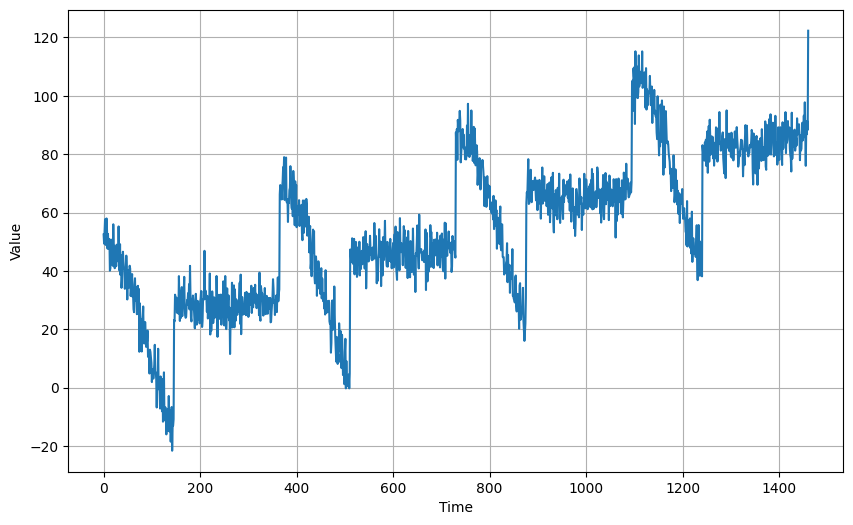

In [5]:
ime = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)




In [6]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset



In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [15]:
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

In [19]:
model.compile(loss = keras.losses.Huber(),
              optimizer = keras.optimizers.SGD(learning_rate= 1e-5, momentum = 0.9),
              metrics = ['mae'])

In [20]:
model.fit(train_set, epochs = 100, validation_data = valid_set)

Epoch 1/100
31/31 [==============================] - 1s 11ms/step - loss: 10.8438 - mae: 11.3330 - val_loss: 10.1367 - val_mae: 10.6265
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 10.4561 - mae: 10.9458 - val_loss: 9.6341 - val_mae: 10.1204
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 10.1655 - mae: 10.6531 - val_loss: 9.7160 - val_mae: 10.2089
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.9927 - mae: 10.4790 - val_loss: 9.5586 - val_mae: 10.0489
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 9.8149 - mae: 10.3069 - val_loss: 9.8481 - val_mae: 10.3337
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.7264 - mae: 10.2172 - val_loss: 9.1603 - val_mae: 9.6469
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5034 - mae: 9.9922 - val_loss: 9.0924 - val_mae: 9.5787
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - 

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

In [24]:
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

In [25]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch/30))

In [26]:
model.compile(optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9),
              loss = keras.losses.Huber(),
              metrics = ['mae'])

In [28]:
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 17.5688 - mae: 18.0615 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 13.1195 - mae: 13.6072 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 12.5338 - mae: 13.0256 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 12.4346 - mae: 12.9256 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 12.3401 - mae: 12.8318 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 12.2223 - mae: 12.7132 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 12.1062 - mae: 12.5979 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 11.9750 - mae: 12.4660 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 11.8417 - mae: 12.3341 

(1e-06, 0.01, 0.0, 20.0)

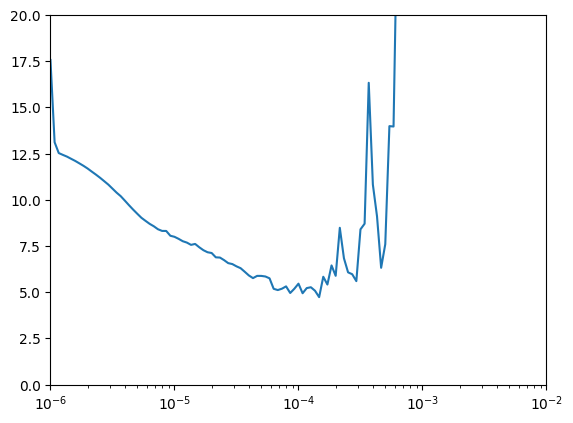

In [29]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-2, 0, 20])

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [33]:
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

In [36]:
model.compile(loss = keras.losses.Huber(),
              optimizer = keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9),
              metrics = ['mae'])

In [40]:
early_stopping = keras.callbacks.EarlyStopping(patience = 10)

model.fit(train_set, epochs = 500, validation_data = valid_set,
          callbacks = [early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 29.4835 - mae: 29.9792 - val_loss: 13.1433 - val_mae: 13.6343
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 13.0394 - mae: 13.5289 - val_loss: 11.2904 - val_mae: 11.7786
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 12.4548 - mae: 12.9422 - val_loss: 10.8267 - val_mae: 11.3123
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 12.1299 - mae: 12.6225 - val_loss: 10.7230 - val_mae: 11.2148
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 11.6842 - mae: 12.1743 - val_loss: 10.3584 - val_mae: 10.8462
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 11.3496 - mae: 11.8375 - val_loss: 10.1456 - val_mae: 10.6368
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 10.9738 - mae: 11.4625 - val_loss: 9.7892 - val_mae: 10.2768
Epoch 8/500
31/31 [==============================] - 0s 

In [41]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [43]:
lin_forecast = model_forecast(model, series[split_time - window_size :-1], window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


In [44]:
lin_forecast.shape

(461,)

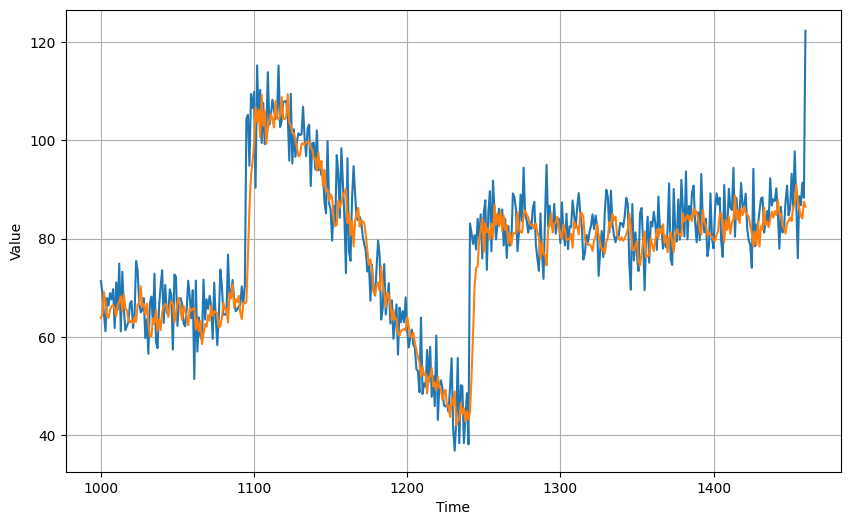

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [50]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.940773

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 67.1672 - mae: 67.6672 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 66.1262 - mae: 66.6262 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 64.8427 - mae: 65.3427 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 63.3998 - mae: 63.8998 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 61.7890 - mae: 62.2890 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 59.9805 - mae: 60.4805 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 57.9733 - mae: 58.4733 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 55.7455 - mae: 56.2454 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 53.3047 - mae: 53.8044 